In [8]:
!pip install kaggle -q 

In [9]:
!pip install scikit-learn

In [10]:
!pip install wordcloud

In [11]:
!pip install nltk

In [12]:
import os
import json
import numpy as np
import pandas as pd
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt





In [13]:
kaggle_config = json.load(open("kaggle.json"))

In [14]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [15]:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [16]:
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
spotify-million-song-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
!ls

kaggle.json
music_player.ipynb
spotify-million-song-dataset.zip
spotify_millsongdata.csv


In [18]:
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [19]:
df = pd.read_csv("spotify_millsongdata.csv")


### Intial Understanding of the data ###

In [20]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [21]:
df.shape


(57650, 4)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [23]:
 df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [24]:
top_Artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists")
print(top_Artists)


Top 10 Artists
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [25]:
df = df.sample(20000)
df = df.drop('link', axis = 1).reset_index(drop=True)

In [26]:
df.shape

(20000, 3)

In [27]:
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(all_lyrics)

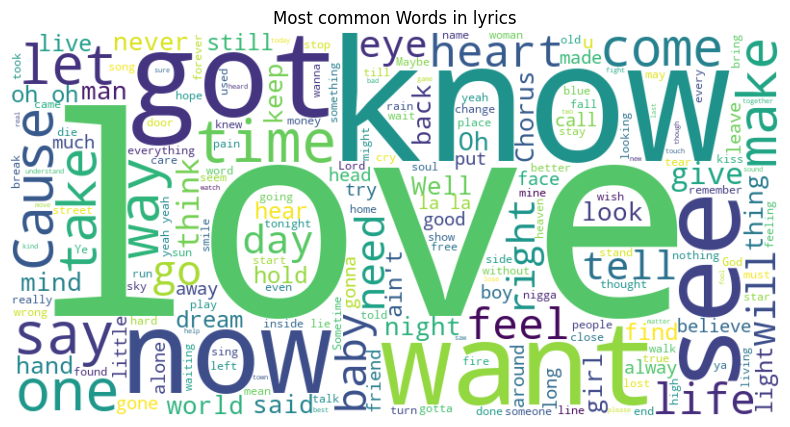

In [28]:
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Most common Words in lyrics")
plt.show()

### Data Preprocessing

In [29]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Prachi
[nltk_data]     Salunkhe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Prachi
[nltk_data]     Salunkhe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Prachi
[nltk_data]     Salunkhe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
stop_words = set(stopwords.words('english'))

In [31]:
def process_text(text):
    #Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    #Convert to lowercase
    text = text.lower()
    #Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [33]:
#Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(process_text)

In [34]:
df.head()

,artist,song,text,cleaned_text
0,Judas Priest,Worth Fighting For,You said I could never find \r\nA way to ease...,said could never find way ease mind id go youd...
1,Thin Lizzy,Thunder And Lightning,Locked up in the classroom waiting for the fig...,locked classroom waiting fight schoolyard knoc...
2,Chris Brown,Biggest Fan,You would think we in a waterbed \r\nAll the ...,would think waterbed sheets soaked im glad ain...
3,Miley Cyrus,Dancing,"Here I am, dancing in the wind \r\nMy back to...",dancing wind back face see ocean apond us near...
4,Elton John,Cold As Christmas,Music by elton john \r\nLyrics by bernie taup...,music elton john lyrics bernie taupin availabl...


In [36]:
#Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [39]:
#Comppute Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [40]:
#Recommendation function
def recommend_songs(song_name, cosine_sim = cosine_sim , df=df , top_n = 5):
    #Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset"
    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x : x[1] , reverse = True)
    sim_scores = sim_scores[1:top_n+1]
    #Get song indices
    song_indices = [i[0] for i in sim_scores]
    #Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]



In [41]:
df['song'][2]

'Biggest Fan'

In [43]:
#Exmaple recommendation
print('\nRecommendations for the song "Biggest Fan" :' )
recommendations = recommend_songs("Biggest Fan")
print(recommendations)


Recommendations for the song "Biggest Fan" :
             artist            song
12460        Xzibit   Family Values
2333         Prince            Girl
18301  Phil Collins         My Girl
6913    Chris Brown  Leave The Club
9542       Flo-Rida      Respirator
